In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sb
from sklearn.model_selection import train_test_split

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

**Data Preprocessing**

In [ ]:
# Load train data batches (replace "data_batch_1.npy" with the actual file paths)
data_batch_1 = np.load("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/data_batch_1", encoding='latin1', allow_pickle=True)
data_batch_2 = np.load("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/data_batch_2", encoding='latin1', allow_pickle=True)
data_batch_3 = np.load("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/data_batch_3", encoding='latin1', allow_pickle=True)
# Extract images and labels from each batch
images_batch_1, labels_batch_1 = data_batch_1['data'], data_batch_1['labels']
images_batch_2, labels_batch_2 = data_batch_2['data'], data_batch_2['labels']
images_batch_3, labels_batch_3 = data_batch_3['data'], data_batch_3['labels']
# Convert your numpy arrays to PyTorch tensors
images_batch_1 = torch.tensor(images_batch_1, dtype=torch.float32)
images_batch_1 = images_batch_1.view(10000, 3, 32, 32)
labels_batch_1 = torch.tensor(labels_batch_1, dtype=torch.long)

images_batch_2 = torch.tensor(images_batch_2, dtype=torch.float32)
images_batch_2 = images_batch_2.view(10000, 3, 32, 32)
labels_batch_2 = torch.tensor(labels_batch_2, dtype=torch.long)

images_batch_3 = torch.tensor(images_batch_3, dtype=torch.float32)
images_batch_3 = images_batch_3.view(10000, 3, 32, 32)
labels_batch_3 = torch.tensor(labels_batch_3, dtype=torch.long)

# Create datasets and corresponding DataLoader objects for each batch
train_dataset_1 = TensorDataset(images_batch_1, labels_batch_1)
train_dataset_2 = TensorDataset(images_batch_2, labels_batch_2)
train_dataset_3 = TensorDataset(images_batch_3, labels_batch_3)

# Concatenate the training datasets
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2, train_dataset_3])

# Extract labels from the concatenated dataset
all_labels = [label for _, label in train_dataset]

# Split the concatenated dataset into training and validation sets while preserving class distribution
train_dataset, val_dataset = train_test_split(train_dataset, test_size=(1/9), stratify=all_labels, random_state=25)


# Create DataLoader objects for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#testdataset
data_batch_test = np.load("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/test_batch", encoding='latin1', allow_pickle=True)
images_batch_test, labels_batch_test = data_batch_test['data'], data_batch_test['labels']

images_batch_test = torch.tensor(images_batch_test, dtype=torch.float32)
images_batch_test = images_batch_test.view(10000, 3, 32, 32)
labels_batch_test = torch.tensor(labels_batch_test, dtype=torch.long)

test_dataset = TensorDataset(images_batch_test, labels_batch_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Hidden Set

hidden_test_image = np.load("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/test_additional.npy")
hidden_test_label = np.load("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/labels.npy")

hidden_batch_image = torch.tensor(hidden_test_image, dtype=torch.float32)
hidden_batch_image = torch.permute(hidden_batch_image,(0,3,1,2))
print(np.shape(hidden_batch_image))
hidden_batch_label = torch.tensor(hidden_test_label, dtype = torch.long)
print(np.shape(hidden_batch_label))
hidden_test_set = TensorDataset(hidden_batch_image, hidden_batch_label)
hidden_test_loader = DataLoader(hidden_test_set, batch_size, shuffle = True)

torch.Size([10000, 3, 32, 32])
torch.Size([10000])


**Using Sigmoid func as Activation function**

In [ ]:
class CustomCNN_Sig(nn.Module):
    def __init__(self):
        super(CustomCNN_Sig, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3, stride= 1, padding= 1),
            #nn.BatchNorm2d(32),
            nn.Sigmoid(),
            nn.Conv2d(in_channels = 32, out_channels= 64,kernel_size= 3, stride= 1, padding= 1),
            #nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(2,2)
            )
        #max Polling reduces the dimension of image from 30*30 to 15*15, but number of channels (hidden units is same as 64)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, stride= 1, padding= 1),
            #nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, stride= 1, padding= 1),
           # nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
            )

        #Classifier Layers: In_features will have a shape equal to the flattened output layer of the last output layer

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(in_features=256 * 8 * 8, out_features=128),
            nn.Linear(in_features=128, out_features=10),# Corrected input size
        )



    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        #x = F.softmax(x, dim=1)
        return x

**Using ReLU as Activation function**

In [ ]:
class CustomCNN_Relu(nn.Module):
    def __init__(self):
        super(CustomCNN_Relu, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(in_features=256 * 8 * 8, out_features=128),
            nn.Linear(in_features=128, out_features=10),# Corrected input size
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        #x = F.softmax(x, dim=1)
        return x



In [ ]:
sample_input = torch.randn(1, 3, 32, 32)  # Assuming a batch size of 1 and input images of size 32x32 with 3 channels

model1 = CustomCNN_Sig()
# Pass the input tensor through the layers up to conv_block2
output_conv_block1 = model1.conv_block1(sample_input)
print(output_conv_block1.shape)
output_conv_block2 = model1.conv_block2(output_conv_block1)

# Print the shape of the output tensor produced by conv_block2
print("Output size of conv_block2:", output_conv_block2.shape)

model2 = CustomCNN_Relu()
# Pass the input tensor through the layers up to conv_block2
output_conv_block1 = model2.conv_block1(sample_input)
print(output_conv_block1.shape)
output_conv_block2 = model2.conv_block2(output_conv_block1)

# Print the shape of the output tensor produced by conv_block2
print("Output size of conv_block2:", output_conv_block2.shape)

torch.Size([1, 64, 16, 16])
Output size of conv_block2: torch.Size([1, 256, 8, 8])
torch.Size([1, 64, 16, 16])
Output size of conv_block2: torch.Size([1, 256, 8, 8])


**Training Loop**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms. Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
def train_model(model, train_loader, criterion, optimizer,num_epochs=17):
  # Training phase
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    model.eval()
    # Variables to store validation loss and accuracy
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    # Validation loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)


    model.train()
   # scheduler.step()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1]}')

    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    print(f'Epoch {epoch+1}, Val Loss: {val_losses[-1]}, Accuracy: {val_accuracies[-1]}')



  print('Finished Training')
  return train_accuracies[-1], val_accuracies[-1], train_losses, val_losses, train_accuracies, val_accuracies



**Evaluation loop**

In [ ]:
def test_model(model, test_loader):
  model.eval()  # Set the model2 to evaluation mode
  correct = 0
  total = 0
  true_labels = []
  predicted_labels = []
  with torch.no_grad():
      for inputs, labels in test_loader:  # Iterate over your test batch
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          true_labels.extend(labels.cpu().numpy())
          predicted_labels.extend(predicted.cpu().numpy())
  return (correct / total), true_labels, predicted_labels

**Plotting Accurachy_Loss**

In [ ]:
def plot_acc_loss(act_type, train_losses, train_accuracies, val_losses, val_accuracies):
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title(f'Loss over Epochs ({act_type})')
#   plt.ylim(1.6, 2.3)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label='Training Accuracy')
  plt.plot(val_accuracies, label='Val Accuracy')
  plt.title(f'Accuracy over Epochs ({act_type})')
#   plt.ylim(0.2, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

**Plotting confussion matrix**

In [ ]:

def plot_conf_mat(true_labels, predicted_labels):
  # Calculate the confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, cm_plot = plt.subplots(figsize=(8, 6))
  cm_plot = sb.heatmap(cm_normalized, cmap = "Blues", annot = True, fmt='.2f')
  cm_plot.set_xlabel('Predictions')
  cm_plot.set_ylabel('Actuals')

In [ ]:
def train_test_model(model, act_type, optimizer):
  train_acc, val_acc, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, criterion, optimizer)
  print('Accuracy on the train set: %d %%' % (100 * train_acc))
#   np.save('loss_acc.npy', [train_losses, train_accuracies, val_losses, val_accuracies])
  plot_acc_loss(act_type, train_losses, train_accuracies, val_losses, val_accuracies)

  test_acc, true_labels, predicted_labels = test_model(model, test_loader)
  print('Accuracy on the test set: %d %%' % (100 * test_acc))
#   np.save('test_true_pred.npy', [true_labels, predicted_labels])
  plot_conf_mat(true_labels, predicted_labels)

  htest_acc, htrue_labels, hpredicted_labels = test_model(model, hidden_test_loader)
  print('Accuracy on the hidden test set: %d %%' % (100 * htest_acc))
#   np.save('htest_true_pred.npy', [htrue_labels, hpredicted_labels])
  plot_conf_mat(htrue_labels, hpredicted_labels)

In [ ]:
criterion = nn.CrossEntropyLoss()

Epoch 1, Train Loss: 2.3520975433093465, Accuracy: 0.09603990099752494
Epoch 1, Val Loss: 2.3027592727116177, Accuracy: 0.09988002399520096
Epoch 2, Train Loss: 2.3031176345811475, Accuracy: 0.0975774394359859
Epoch 2, Val Loss: 2.302847521645682, Accuracy: 0.10077984403119376
Epoch 3, Train Loss: 2.302998366973383, Accuracy: 0.10046501162529063
Epoch 3, Val Loss: 2.302819878714425, Accuracy: 0.10047990401919617
Epoch 4, Train Loss: 2.13955016888017, Accuracy: 0.1978174454361359
Epoch 4, Val Loss: 1.9512997082301549, Accuracy: 0.28074385122975404
Epoch 5, Train Loss: 1.8887962924776602, Accuracy: 0.3088577214430361
Epoch 5, Val Loss: 1.798794510251, Accuracy: 0.3395320935812837
Epoch 6, Train Loss: 1.7293118598649828, Accuracy: 0.36413410335258384
Epoch 6, Val Loss: 1.6529103653771537, Accuracy: 0.39862027594481103
Epoch 7, Train Loss: 1.6399059221327161, Accuracy: 0.4018600465011625
Epoch 7, Val Loss: 1.583919298081171, Accuracy: 0.41061787642471503
Epoch 8, Train Loss: 1.549610835042

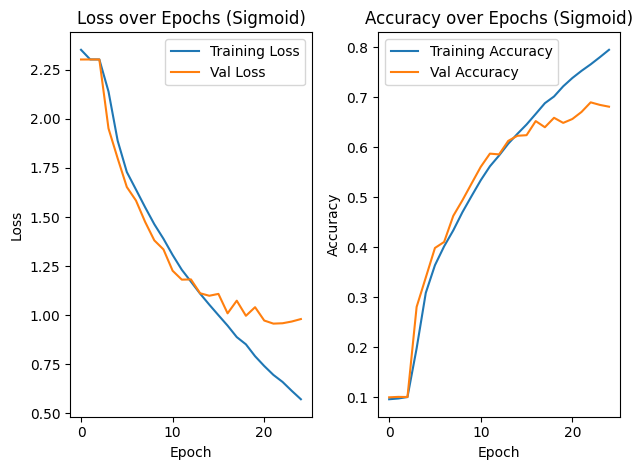

Accuracy on the test set: 66 %
Accuracy on the hidden test set: 59 %


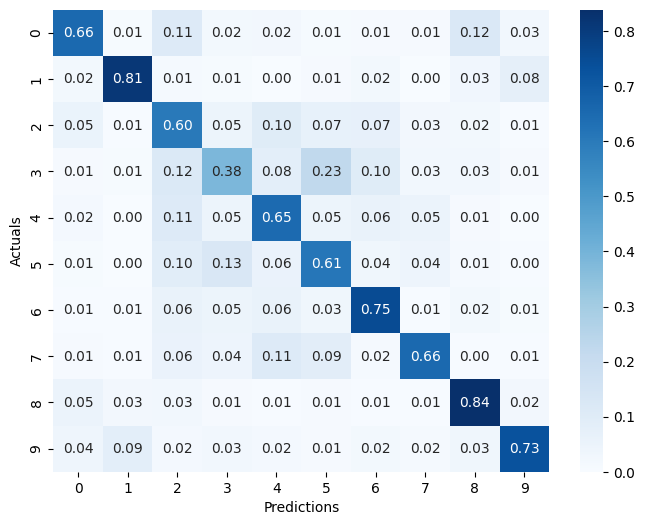

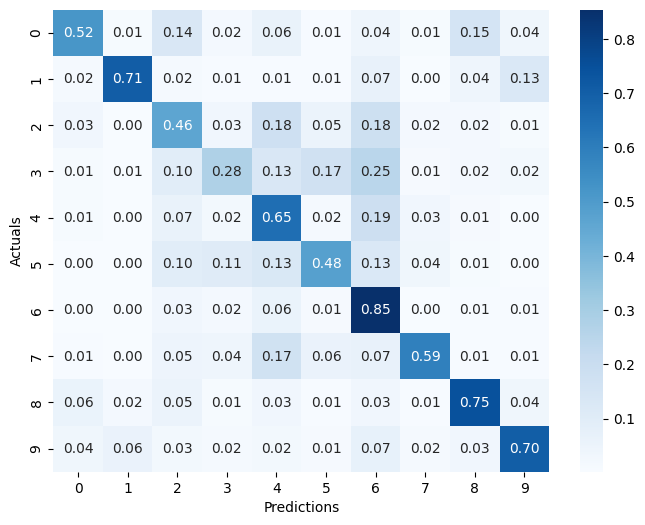

In [ ]:
model1 = CustomCNN_Sig().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr = 0.001)
#scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)
train_test_model(model1, 'Sigmoid', optimizer1)

Epoch 1, Train Loss: 1.5312432605299733, Accuracy: 0.4626865671641791
Epoch 1, Val Loss: 1.203506978920528, Accuracy: 0.5734853029394121
Epoch 2, Train Loss: 1.120190397726832, Accuracy: 0.6027525688142203
Epoch 2, Val Loss: 1.0517391363779705, Accuracy: 0.6367726454709058
Epoch 3, Train Loss: 0.9587443226890312, Accuracy: 0.6621540538513463
Epoch 3, Val Loss: 0.946399690423693, Accuracy: 0.6754649070185963
Epoch 4, Train Loss: 0.8194325982237891, Accuracy: 0.7142053551338784
Epoch 4, Val Loss: 0.906264861424764, Accuracy: 0.6820635872825435
Epoch 5, Train Loss: 0.7241195966299775, Accuracy: 0.7493812345308632
Epoch 5, Val Loss: 0.8560445808228992, Accuracy: 0.7006598680263947
Epoch 6, Train Loss: 0.6249142503030867, Accuracy: 0.7797944948623715
Epoch 6, Val Loss: 0.8312215989544278, Accuracy: 0.7264547090581883
Epoch 7, Train Loss: 0.5406682594216985, Accuracy: 0.8125703142578564
Epoch 7, Val Loss: 0.8341269251846132, Accuracy: 0.7288542291541692
Epoch 8, Train Loss: 0.475733506870712

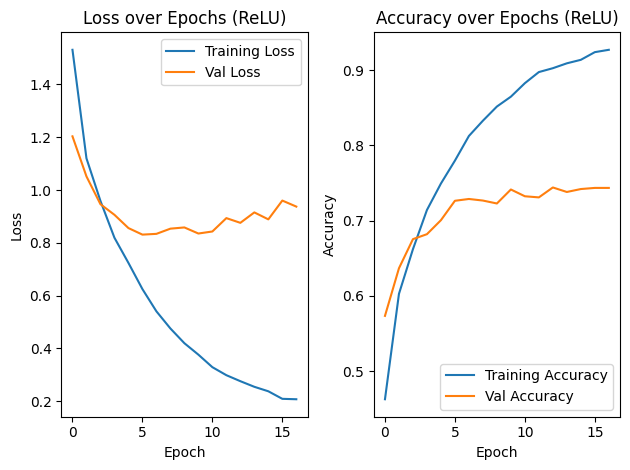

Accuracy on the test set: 73 %
Accuracy on the hidden test set: 62 %


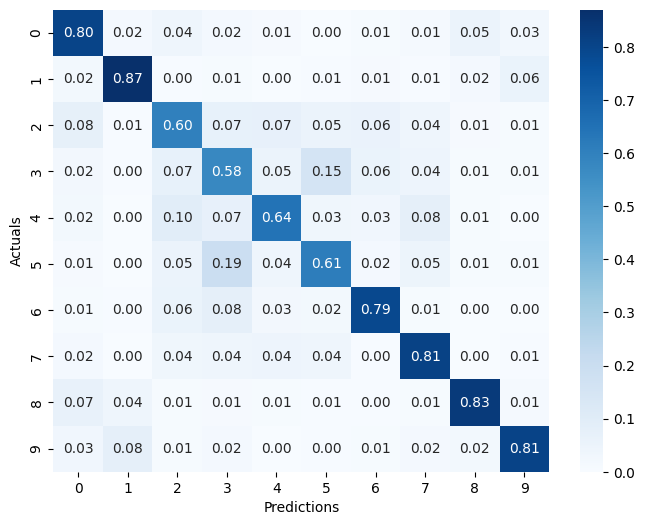

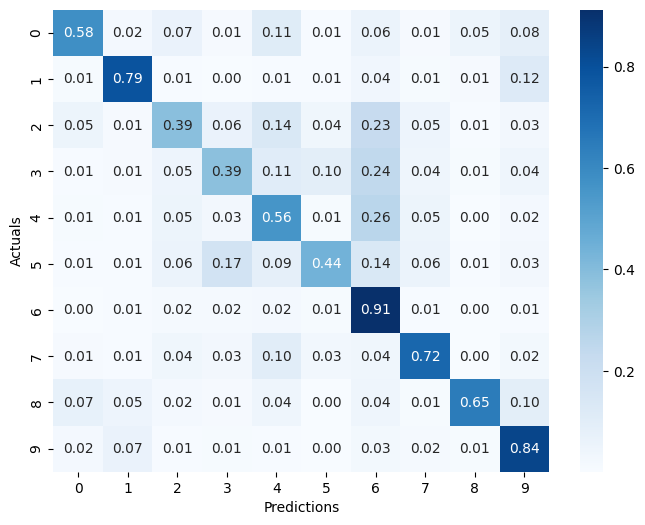

In [ ]:
model2 = CustomCNN_Relu().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr = 0.0001)
#scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)
train_test_model(model2, 'ReLU', optimizer2)